This notebook is an exploratory data analysis and workflow that determines if and how to best
impute values for suppressed crop-variety data in the MASC data found here:
https://www.masc.mb.ca/masc.nsf/mmpp_browser_variety.html
This notebook is not intended for production and is meant, ultimately, as a guide to create
a production script for imputation. Therefore, commenting is at a minimum and workflow
isn't structured. Production notes can be found in the repo's README.md file and
project methodology found in the 'reports' folder.

In [1]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

In [2]:

# set project root and year
project_root = Path.cwd().parents[0]
year = 2024  # change as needed

# define input paths
raw_path = project_root / "data" / "raw" / str(year) / f"masc_{year}.xlsx"
summary_path = project_root / "data" / "reference" / "masc_summary.csv"

# load data
masc_df = pd.read_excel(raw_path, engine="calamine")
summary_df = pd.read_csv(summary_path)

# display basic info
print(f"Loaded {len(masc_df)} rows for {year}")
masc_df.head()

Loaded 11389 rows for 2024


,MMPP - Variety Yield Data Browser,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9
0,Year,Risk Area / R.M.,Crop,Variety,Farms,Acres,Yield/acre(Metric),Yield/acre(Metric),Yield/acre(Imperial),Yield/acre(Imperial)
1,2024,HARRISON PARK,ALFALFA/GRASS MIX.,NO VAR (VARIETY TYPE UNKNOWN),9,949,707.152 Tonnes,Tonnes,779.281 Tons,Tons
2,2024,GLENBORO-SOUTH CYPRESS,PROC POTATOES-IRRIG,RUSSET BURBANK (GEMS),6,"2,971.0",19.311 Tonnes,Tonnes,425.73 CWT,CWT
3,2024,NORFOLK-TREHERNE,PROC POTATOES-IRRIG,UMATILLA RUSSET,3,773,18.427 Tonnes,Tonnes,406.23 CWT,CWT
4,2024,NORFOLK-TREHERNE,PROC POTATOES-IRRIG,RUSSET BURBANK (GEMS),3,696,18.169 Tonnes,Tonnes,400.56 CWT,CWT


In [3]:
# drop the first metadata row
masc_df = masc_df.drop(0).reset_index(drop=True)

# set proper headers
masc_df.columns = [
    "year",
    "rm",
    "crop",
    "variety",
    "farms",
    "acres",
    "yield_per_acre",
    "metric_unit",
    "imperial_value",
    "imperial_unit",
]

# keep only needed columns
masc_df = masc_df[["year", "rm", "crop", "variety", "farms", "acres", "yield_per_acre"]]

# show sample
masc_df.head()

,year,rm,crop,variety,farms,acres,yield_per_acre
0,2024,HARRISON PARK,ALFALFA/GRASS MIX.,NO VAR (VARIETY TYPE UNKNOWN),9,949,707.152 Tonnes
1,2024,GLENBORO-SOUTH CYPRESS,PROC POTATOES-IRRIG,RUSSET BURBANK (GEMS),6,"2,971.0",19.311 Tonnes
2,2024,NORFOLK-TREHERNE,PROC POTATOES-IRRIG,UMATILLA RUSSET,3,773,18.427 Tonnes
3,2024,NORFOLK-TREHERNE,PROC POTATOES-IRRIG,RUSSET BURBANK (GEMS),3,696,18.169 Tonnes
4,2024,MOUNTAIN,COARSE HAY,NO VAR (TYPE UNKNOWN),6,725,359.582 Tonnes


In [4]:
masc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11388 entries, 0 to 11387
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   year            11388 non-null  object
 1   rm              11388 non-null  object
 2   crop            11388 non-null  object
 3   variety         11381 non-null  object
 4   farms           11388 non-null  object
 5   acres           11388 non-null  object
 6   yield_per_acre  11388 non-null  object
dtypes: object(7)
memory usage: 622.9+ KB


In [5]:
# split numeric part
masc_df["yield_per_acre"] = masc_df["yield_per_acre"].str.split().str[0]

# convert safely to numeric
masc_df["yield_per_acre"] = pd.to_numeric(masc_df["yield_per_acre"], errors="coerce")

# convert other numeric columns
masc_df["farms"] = pd.to_numeric(masc_df["farms"], errors="coerce").astype("Int64")
masc_df["acres"] = (
    masc_df["acres"].astype(str).str.replace(",", "", regex=False)
)
masc_df["acres"] = pd.to_numeric(masc_df["acres"], errors="coerce")
masc_df["year"] = pd.to_numeric(masc_df["year"], errors="coerce").astype("Int64")

In [6]:
masc_df['yield'] = masc_df['acres'] * masc_df['yield_per_acre']

In [7]:
masc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11388 entries, 0 to 11387
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   year            11388 non-null  Int64  
 1   rm              11388 non-null  object 
 2   crop            11388 non-null  object 
 3   variety         11381 non-null  object 
 4   farms           2627 non-null   Int64  
 5   acres           2627 non-null   float64
 6   yield_per_acre  2627 non-null   float64
 7   yield           2627 non-null   float64
dtypes: Int64(2), float64(3), object(3)
memory usage: 734.1+ KB


In [8]:
summary_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   year                   8 non-null      int64  
 1   records                8 non-null      int64  
 2   varieties              8 non-null      int64  
 3   total_acres            8 non-null      float64
 4   yield_tonnes_per_acre  8 non-null      float64
 5   Unnamed: 5             0 non-null      float64
 6   Unnamed: 6             0 non-null      float64
 7   Unnamed: 7             0 non-null      float64
 8   Unnamed: 8             0 non-null      float64
dtypes: float64(6), int64(3)
memory usage: 708.0 bytes


In [9]:
acres_sum = masc_df["acres"].sum()
print(f"Acres in masc_df:  {acres_sum}")
summary_acres_sum = summary_df.loc[summary_df['year'] == year, 'total_acres'].iloc[0]
print(f"Acres in summary_df for year {year}: {summary_acres_sum}")
acres_diff = summary_acres_sum - acres_sum
print(f"A difference of {acres_diff}")

Acres in masc_df:  7822301.4
Acres in summary_df for year 2024: 9945150.2
A difference of 2122848.799999999


In [10]:
# Calculate total yield from masc_df
yield_sum = masc_df["yield"].sum()
print(f"Yield in masc_df:  {yield_sum}")

# Extract official total yield (from summary_df)
summary_total_acres = summary_df.loc[summary_df["year"] == year, "total_acres"].iloc[0]
summary_yield_per_acre = summary_df.loc[summary_df["year"] == year, "yield_tonnes_per_acre"].iloc[0]
summary_yield_sum = summary_total_acres * summary_yield_per_acre
print(f"Yield in summary_df for year {year}: {summary_yield_sum}")

# Compute the yield gap (tonnes)
yield_diff = summary_yield_sum - yield_sum
print(f"A difference of {yield_diff} tonnes")

Yield in masc_df:  14115086.5953
Yield in summary_df for year 2024: 20278161.2578
A difference of 6163074.6625000015 tonnes


In [11]:
missing_df = masc_df[masc_df["yield_per_acre"].isna() | masc_df["farms"].isna() | masc_df["acres"].isna()]
print(f"Rows needing imputation: {len(missing_df)}")
missing_df.head(10)

Rows needing imputation: 8761


,year,rm,crop,variety,farms,acres,yield_per_acre,yield
2627,2024,ALEXANDER,ALFALFA,NO VAR,<NA>,NaN,NaN,NaN
2628,2024,ALEXANDER,ALFALFA/GRASS MIX.,NO VAR (VARIETY TYPE UNKNOWN),<NA>,NaN,NaN,NaN
2629,2024,ALEXANDER,ARGENTINE CANOLA,B3018N (BREVANT) (LT),<NA>,NaN,NaN,NaN
2630,2024,ALEXANDER,ARGENTINE CANOLA,DKLL 83 SC (DEKALB) (LT),<NA>,NaN,NaN,NaN
2631,2024,ALEXANDER,ARGENTINE CANOLA,L345PC (INVIGOR) (LT),<NA>,NaN,NaN,NaN
2632,2024,ALEXANDER,BLACK BEANS,ECLIPSE,<NA>,NaN,NaN,NaN
2633,2024,ALEXANDER,COMMON ALFALFA SEED,ALGONQUIN,<NA>,NaN,NaN,NaN
2634,2024,ALEXANDER,COMMON ALFALFA SEED,NO VAR,<NA>,NaN,NaN,NaN
2635,2024,ALEXANDER,GRAIN CORN,P7455R (PIONEER) (RT),<NA>,NaN,NaN,NaN
2636,2024,ALEXANDER,GRASSES,NO VAR,<NA>,NaN,NaN,NaN


In [12]:
valid_df = masc_df[
    masc_df["farms"].notna() &
    masc_df["acres"].notna() &
    masc_df["yield_per_acre"].notna()
]

print(f"Valid rows: {len(valid_df)}")
valid_df.head(20)

Valid rows: 2627


,year,rm,crop,variety,farms,acres,yield_per_acre,yield
0,2024,HARRISON PARK,ALFALFA/GRASS MIX.,NO VAR (VARIETY TYPE UNKNOWN),9,949.0,707.152,671087.248
1,2024,GLENBORO-SOUTH CYPRESS,PROC POTATOES-IRRIG,RUSSET BURBANK (GEMS),6,2971.0,19.311,57372.981
2,2024,NORFOLK-TREHERNE,PROC POTATOES-IRRIG,UMATILLA RUSSET,3,773.0,18.427,14244.071
3,2024,NORFOLK-TREHERNE,PROC POTATOES-IRRIG,RUSSET BURBANK (GEMS),3,696.0,18.169,12645.624
4,2024,MOUNTAIN,COARSE HAY,NO VAR (TYPE UNKNOWN),6,725.0,359.582,260696.950
5,2024,GLENBORO-SOUTH CYPRESS,PROC POTATOES-IRRIG,RANGER RUSSET (AMISK),3,1227.0,17.600,21595.200
6,2024,DUFFERIN,PROC POTATOES-IRRIG,RUSSET BURBANK (GEMS),3,3245.0,17.276,56060.620
7,2024,VICTORIA,PROC POTATOES-IRRIG,RUSSET BURBANK (GEMS),3,1124.0,17.067,19183.308
8,2024,WESTLAKE-GLADSTONE,PROC POTATOES-IRRIG,RUSSET BURBANK (GEMS),3,1116.0,16.344,18239.904
9,2024,NORTH NORFOLK,PROC POTATOES-IRRIG,RUSSET BURBANK (GEMS),6,3128.0,16.003,50057.384


Imputation strategy:
1) Hypothesis: all rm's behave the same.
2) Using valid_df, sum the acres as total_acres for each rm and find the percentage of acres that each rm contributes to the province for KNOWN values.
3) Using missing_df, find out how many crop_var = (crop + variety) entries there are per rm
4) Look to see if there is a correlation between the total_acres for each rm and crop_var per rm
5) The strength of this correlation is a measure of 'all things being equal' and my imputation strategy going forward.

In [13]:
# total known acres per rm
rm_acres = (
    valid_df.groupby("rm", as_index=False)["acres"]
    .sum()
    .rename(columns={"acres": "total_acres"})
)

# percentage contribution of each rm to known provincial acres
total_known_acres = rm_acres["total_acres"].sum()
rm_acres["pct_of_total"] = rm_acres["total_acres"] / total_known_acres * 100

# number of crop_var entries per rm in missing_df
missing_df["crop_var"] = missing_df["crop"].astype(str) + " | " + missing_df["variety"].astype(str)
rm_missing_counts = (
    missing_df.groupby("rm", as_index=False)["crop_var"]
    .nunique()
    .rename(columns={"crop_var": "missing_crop_var_count"})
)

# merge the two summaries
rm_summary = rm_acres.merge(rm_missing_counts, on="rm", how="outer").fillna(0)

# compute correlation
corr_val = rm_summary["total_acres"].corr(rm_summary["missing_crop_var_count"])
print(f"Correlation between RM total acres and number of missing crop_var entries: {corr_val:.3f}")

rm_summary.head(20)


Correlation between RM total acres and number of missing crop_var entries: 0.720


/var/folders/36/_jr9z14n69x_lzy_7969swfh0000gs/T/ipykernel_58021/4119435020.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_df["crop_var"] = missing_df["crop"].astype(str) + " | " + missing_df["variety"].astype(str)


,rm,total_acres,pct_of_total,missing_crop_var_count
0,ALEXANDER,15848.0,0.202600,36
1,ALONSA,37334.0,0.477276,62
2,ARGYLE,87346.5,1.116634,124
3,ARMSTRONG,4568.0,0.058397,41
4,BIFROST-RIVERTON,78799.5,1.007370,116
5,BOISSEVAIN-MORTON,111727.0,1.428314,107
6,BRENDA-WASKADA,116465.0,1.488884,93
7,BROKENHEAD,62843.0,0.803382,106
8,CARTIER,84953.0,1.086036,88
9,CARTWRIGHT-ROBLIN,82412.0,1.053552,92


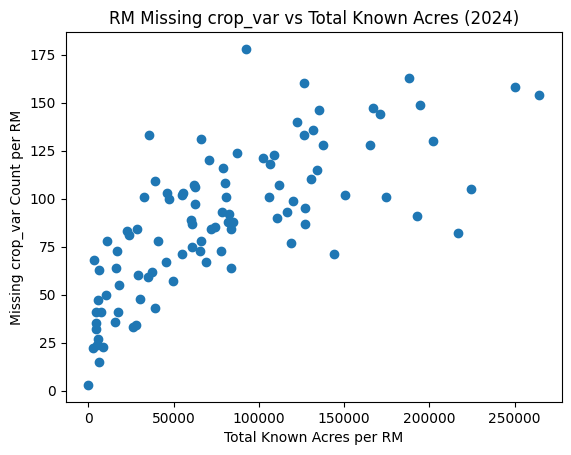

In [14]:
# simple scatter to visualize the relationship
plt.scatter(rm_summary["total_acres"], rm_summary["missing_crop_var_count"])
plt.xlabel("Total Known Acres per RM")
plt.ylabel("Missing crop_var Count per RM")
plt.title(f"RM Missing crop_var vs Total Known Acres ({year})")
plt.show()

In [15]:
crop_stats = (
    valid_df.groupby("crop", as_index=False)
    .agg({"acres": "sum", "farms": "sum", "yield": "sum"})
)
crop_stats["avg_acres_per_farm"] = crop_stats["acres"] / crop_stats["farms"]
crop_stats["avg_yield_per_farm"] = crop_stats["yield"] / crop_stats["farms"]
crop_stats["yield_tonnes_per_acre"] = crop_stats["yield"] / crop_stats["acres"]
crop_stats.sort_values("avg_acres_per_farm", ascending=False)


,crop,acres,farms,yield,avg_acres_per_farm,avg_yield_per_farm,yield_tonnes_per_acre
24,PROC POTATOES-IRRIG,42101.0,75,6.375325e+05,561.346667,8500.432733,15.142929
15,NORTH. HARD RED WHT,115193.0,258,2.341936e+05,446.484496,907.727186,2.033054
25,RED SPRING WHEAT,2503721.9,6136,4.533974e+06,408.038119,738.913689,1.810894
22,PRAIRIE SPRING WHEAT,25949.2,71,5.080548e+04,365.48169,715.570197,1.957882
2,ARGENTINE CANOLA,2767810.4,7714,2.371394e+06,358.803526,307.414292,0.856776
21,PINTO BEANS,84589.0,260,8.742627e+04,325.342308,336.2549,1.033542
4,BLACK BEANS,28809.0,100,2.741920e+04,288.09,274.19199,0.951758
30,WINTER WHEAT,2837.0,10,4.922568e+03,283.7,492.2568,1.735131
27,SOYBEANS,867177.5,3272,1.094626e+06,265.029798,334.543383,1.262286
14,HYBRID FALL RYE,14574.0,55,3.825022e+04,264.981818,695.458473,2.624552


In [16]:
crop_stats.sort_values("avg_yield_per_farm", ascending=False)

,crop,acres,farms,yield,avg_acres_per_farm,avg_yield_per_farm,yield_tonnes_per_acre
24,PROC POTATOES-IRRIG,42101.0,75,6.375325e+05,561.346667,8500.432733,15.142929
5,COARSE HAY,33179.0,205,7.032092e+05,161.84878,3430.288824,21.194406
23,PROC POTATOES-DRYLND,903.0,5,1.286414e+04,180.6,2572.8276,14.246000
26,SILAGE CORN,13744.0,91,1.722906e+05,151.032967,1893.303407,12.535696
28,TABLE POTATOES,515.0,4,6.399905e+03,128.75,1599.97625,12.427000
0,ALFALFA,52536.0,529,6.666359e+05,99.311909,1260.181272,12.689125
15,NORTH. HARD RED WHT,115193.0,258,2.341936e+05,446.484496,907.727186,2.033054
1,ALFALFA/GRASS MIX.,125551.0,1321,1.044483e+06,95.042392,790.67589,8.319192
11,GRAIN CORN,316298.4,1540,1.204530e+06,205.388571,782.162657,3.808209
25,RED SPRING WHEAT,2503721.9,6136,4.533974e+06,408.038119,738.913689,1.810894


In [17]:
# stable crop anchors (never remapped)
stable_crops = [
    "ARGENTINE CANOLA", "RED SPRING WHEAT", "SOYBEANS",
    "FIELD PEAS", "BARLEY", "OATS", "GRAIN CORN",
    "PASTURE (TAME/PERENNIAL)", "COARSE HAY"
]

# universal proxy map covering all MASC-listed crops
proxy_map = {
    # oilseeds
    "POLISH CANOLA": "ARGENTINE CANOLA",
    "RAPESEED": "ARGENTINE CANOLA",
    "OIL SUNFLOWERS": "ARGENTINE CANOLA",
    "NON-OIL SUNFLOWERS": "ARGENTINE CANOLA",
    "HEMP GRAIN": "SOYBEANS",
    "ORGANIC HEMP GRAIN": "SOYBEANS",
    "MUSTARD": "ARGENTINE CANOLA",
    "FLAX": "ARGENTINE CANOLA",
    "ORGANIC FLAX": "ARGENTINE CANOLA",
    "PHACELIA": "ARGENTINE CANOLA",

    # cereals and small grains
    "RED SPRING WHEAT": "RED SPRING WHEAT",
    "NORTH. HARD RED WHT": "RED SPRING WHEAT",
    "PRAIRIE SPRING WHEAT": "RED SPRING WHEAT",
    "OTHER SPRING WHEAT": "RED SPRING WHEAT",
    "DURUM WHEAT": "RED SPRING WHEAT",
    "HARD WHITE WHEAT": "RED SPRING WHEAT",
    "EXTRA STRONG WHEAT": "RED SPRING WHEAT",
    "WINTER WHEAT": "RED SPRING WHEAT",
    "WINTER TRITICALE": "RED SPRING WHEAT",
    "TRITICALE": "RED SPRING WHEAT",
    "EMMER WHEAT": "RED SPRING WHEAT",
    "SPELT": "RED SPRING WHEAT",
    "ORGANIC DURUM WHEAT": "RED SPRING WHEAT",
    "ORGANIC E.S. WHEAT": "RED SPRING WHEAT",
    "ORGANIC H.W. WHEAT": "RED SPRING WHEAT",
    "ORGANIC N.H.R. WHT": "RED SPRING WHEAT",
    "ORGANIC P.S. WHEAT": "RED SPRING WHEAT",
    "ORGANIC R.S. WHEAT": "RED SPRING WHEAT",
    "ORGANIC SPR WHT OTHR": "RED SPRING WHEAT",
    "ORGANIC WINTER WHEAT": "RED SPRING WHEAT",
    "OPEN POL. FALL RYE": "RED SPRING WHEAT",
    "HYBRID FALL RYE": "RED SPRING WHEAT",
    "ORGANIC O P FALL RYE": "RED SPRING WHEAT",
    "OPEN POL SILAGE CORN": "GRAIN CORN",
    "OPEN POLLINATED CORN": "GRAIN CORN",
    "ORGANIC BARLEY": "BARLEY",
    "ORGANIC OATS": "OATS",
    "BARLEY": "BARLEY",
    "BUCKWHEAT": "OATS",
    "OATS": "OATS",
    "MIXED GRAIN": "BARLEY",
    "PROSO MILLET": "OATS",
    "MILLET (FOXTAIL SEED)": "OATS",
    "MILO/GRAIN SORGHUM": "GRAIN CORN",

    # pulses and legumes
    "SOYBEANS": "SOYBEANS",
    "PINTO BEANS": "SOYBEANS",
    "BLACK BEANS": "SOYBEANS",
    "WHITE PEA BEANS": "SOYBEANS",
    "SMALL RED BEANS": "SOYBEANS",
    "CRANBERRY BEANS": "SOYBEANS",
    "KIDNEY BEANS": "SOYBEANS",
    "OTH DRY EDIBLE BEANS": "SOYBEANS",
    "ADZUKI BEANS": "SOYBEANS",
    "FABABEANS": "FIELD PEAS",
    "FIELD PEAS": "FIELD PEAS",
    "LENTILS": "FIELD PEAS",
    "ORGANIC FIELD PEAS": "FIELD PEAS",

    # root and vegetable crops
    "PROC POTATOES-IRRIG": "FIELD PEAS",
    "PROC POTATOES-DRYLND": "FIELD PEAS",
    "TABLE POTATOES": "FIELD PEAS",
    "SUGAR BEETS": "FIELD PEAS",
    "CARROTS": "FIELD PEAS",
    "CAULIFLOWER": "FIELD PEAS",
    "ASPARAGUS": "FIELD PEAS",
    "CUCUMBERS": "FIELD PEAS",
    "SWEET CORN": "FIELD PEAS",
    "RED BEET": "FIELD PEAS",
    "RUTABAGAS": "FIELD PEAS",
    "COOKING ONIONS": "FIELD PEAS",
    "SWEET POTATO": "FIELD PEAS",
    "CABBAGE": "FIELD PEAS",
    "PARSNIPS": "FIELD PEAS",
    "QUINOA": "FIELD PEAS",

    # forage, hay, pasture
    "ALFALFA": "COARSE HAY",
    "ALFALFA/GRASS MIX.": "COARSE HAY",
    "ALFALFA EST OPTION": "COARSE HAY",
    "ALFALFA GRASS EST OP": "COARSE HAY",
    "ALFALFA SEED EST OPT": "COARSE HAY",
    "COMMON ALFALFA SEED": "COARSE HAY",
    "PED. ALFALFA SEED": "COARSE HAY",
    "COARSE HAY": "COARSE HAY",
    "GREENFEED": "COARSE HAY",
    "FORAGE ESTABLISHMENT": "COARSE HAY",
    "CLOVER & BROMEGRASS HAY": "COARSE HAY",
    "CLOVER RD CNRYG & TIM HAY": "COARSE HAY",
    "INTERCROP MIXTURE": "COARSE HAY",
    "SWEET CLOVER": "COARSE HAY",
    "SWEET CLOVER (SEED)": "COARSE HAY",
    "SWEET CLOVER EST OPT": "COARSE HAY",
    "SAINFOIN (FORAGE)": "COARSE HAY",
    "CICER MILKVETCH (FORAGE)": "COARSE HAY",
    "HAIRY VETCH": "COARSE HAY",

    # grass and seed crops
    "GRASSES": "PASTURE (TAME/PERENNIAL)",
    "GRASSES (SEED)": "PASTURE (TAME/PERENNIAL)",
    "GRASSES (SOD)": "PASTURE (TAME/PERENNIAL)",
    "PASTURE (TAME/ANNUAL)": "PASTURE (TAME/PERENNIAL)",
    "PASTURE (TAME/PERENNIAL)": "PASTURE (TAME/PERENNIAL)",
    "PER. RYEGRASS SEED": "PASTURE (TAME/PERENNIAL)",
    "ANNUAL RYEGRASS SEED": "PASTURE (TAME/PERENNIAL)",
    "TALL FESCUE SEED": "PASTURE (TAME/PERENNIAL)",
    "TIMOTHY SEED COMMON": "PASTURE (TAME/PERENNIAL)",
    "PED. TIMOTHY SEED": "PASTURE (TAME/PERENNIAL)",
    "ALSIKE CLOVER (FORAGE)": "PASTURE (TAME/PERENNIAL)",
    "ALSIKE CLOVER (SEED)": "PASTURE (TAME/PERENNIAL)",
    "BIRDSFOOT TREFOIL (SEED)": "PASTURE (TAME/PERENNIAL)",
    "BIRDSFOOT TREFOIL FORAGE": "PASTURE (TAME/PERENNIAL)",
    "FALL GRASS EST OPTN": "PASTURE (TAME/PERENNIAL)",
    "FALL TIMOTHY EST OPT": "PASTURE (TAME/PERENNIAL)",
    "SPRING GRASS EST OPT": "PASTURE (TAME/PERENNIAL)",
    "SPRING TIMOTHY EST O": "PASTURE (TAME/PERENNIAL)",
    "LUPINS (FORAGE)": "PASTURE (TAME/PERENNIAL)",
    "LUPINS (SEED)": "PASTURE (TAME/PERENNIAL)",
    "CARAWAY": "PASTURE (TAME/PERENNIAL)",
    "CANARYSEED": "PASTURE (TAME/PERENNIAL)",

    # silage, corn, and miscellaneous
    "SILAGE CORN": "GRAIN CORN",
    "NON-CORN SILAGE": "GRAIN CORN",
    "TOO WET TO SEED": "COARSE HAY",
    "UNUSED LAND": "COARSE HAY",
    "BUSH/YARD/SLOUGH": "COARSE HAY",
}

In [18]:
# standardize crop names
missing_df["crop"] = missing_df["crop"].str.strip().str.upper()
valid_df["crop"] = valid_df["crop"].str.strip().str.upper()

# keep original names for output
missing_df["original_crop"] = missing_df["crop"]

# proxy key used only for stats
missing_df["proxy_crop"] = missing_df["crop"].map(proxy_map).fillna(missing_df["crop"])

# define stable crops and fallback medians
stable_crops = crop_stats[crop_stats["acres"] >= 10000]["crop"].tolist()
fallback_acres = crop_stats.loc[crop_stats["crop"].isin(stable_crops), "avg_acres_per_farm"].median()
fallback_yield = crop_stats.loc[crop_stats["crop"].isin(stable_crops), "avg_yield_per_farm"].median()

# count missing varieties per proxy crop
missing_counts = (
    missing_df.groupby("proxy_crop", as_index=False)
    .size()
    .rename(columns={"size": "n_missing"})
)

# merge counts and fill missing stats
crop_stats = crop_stats.merge(
    missing_counts,
    left_on="crop",
    right_on="proxy_crop",
    how="left"
).fillna({"n_missing": 0})

crop_stats = crop_stats[crop_stats["n_missing"] > 0].copy()
crop_stats["avg_acres_per_farm"] = crop_stats["avg_acres_per_farm"].fillna(fallback_acres)
crop_stats["avg_yield_per_farm"] = crop_stats["avg_yield_per_farm"].fillna(fallback_yield)

# acreage weights
crop_stats["weight_acres"] = crop_stats["avg_acres_per_farm"] * crop_stats["n_missing"]
crop_stats["weight_norm_acres"] = crop_stats["weight_acres"] / crop_stats["weight_acres"].sum()
crop_stats["crop_imputed_total_acres"] = crop_stats["weight_norm_acres"] * acres_diff

# yield weights
crop_stats["weight_yield"] = crop_stats["avg_yield_per_farm"] * crop_stats["n_missing"]
crop_stats["weight_norm_yield"] = crop_stats["weight_yield"] / crop_stats["weight_yield"].sum()
crop_stats["crop_imputed_total_yield"] = crop_stats["weight_norm_yield"] * yield_diff

# merge back to missing_df using proxy key, keep original crop column
missing_df = missing_df.merge(
    crop_stats[["crop", "n_missing", "crop_imputed_total_acres", "crop_imputed_total_yield"]],
    left_on="proxy_crop",
    right_on="crop",
    how="left"
)
missing_df = missing_df.drop(columns=["crop_y"], errors="ignore").rename(columns={"crop_x": "crop"})

# per-variety allocation
missing_df["imputed_acres"] = missing_df["crop_imputed_total_acres"] / missing_df["n_missing"]
missing_df["imputed_yield_tonnes"] = missing_df["crop_imputed_total_yield"] / missing_df["n_missing"]

# checks
print("Acreage check:", missing_df["imputed_acres"].sum(), "expected:", acres_diff)
print("Yield check:", missing_df["imputed_yield_tonnes"].sum(), "expected:", yield_diff)


Acreage check: 2122848.799999999 expected: 2122848.799999999
Yield check: 6163074.6625000015 expected: 6163074.6625000015


/var/folders/36/_jr9z14n69x_lzy_7969swfh0000gs/T/ipykernel_58021/4110636778.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_df["crop"] = missing_df["crop"].str.strip().str.upper()
/var/folders/36/_jr9z14n69x_lzy_7969swfh0000gs/T/ipykernel_58021/4110636778.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["crop"] = valid_df["crop"].str.strip().str.upper()
/var/folders/36/_jr9z14n69x_lzy_7969swfh0000gs/T/ipykernel_58021/4110636778.py:6: SettingWithCopyWarning: 
A value is trying to be s

In [19]:
# provincial total check
missing_df["imputed_acres"].sum()

np.float64(2122848.799999999)

In [20]:
# per-RM totals (confirm larger RMs get more)
missing_df.groupby("rm")["imputed_acres"].sum().sort_values(ascending=False).head(10)

rm
STANLEY               42147.631218
TWO BORDERS           38321.403476
WESTLAKE-GLADSTONE    37782.112046
PORTAGE LA PRAIRIE    37098.256875
WALLACE-WOODWORTH     36883.457473
NORTH NORFOLK         36678.379186
RHINELAND             34814.418446
DUFFERIN              34536.780421
GRASSLAND             33541.512453
GREY                  33139.382955
Name: imputed_acres, dtype: Float64

In [21]:

# per-crop totals (confirm alignment with known crop_pct_of_total)
missing_df.groupby("crop")["imputed_acres"].sum().sort_values(ascending=False).head(10)


crop
ARGENTINE CANOLA      446948.107992
SOYBEANS              343212.448987
RED SPRING WHEAT      175361.646284
GRAIN CORN            152961.313999
SILAGE CORN           139711.161958
OATS                  100681.529118
BARLEY                 92677.099246
ALFALFA/GRASS MIX.     79077.391546
FIELD PEAS             55689.850388
ALFALFA                48828.369925
Name: imputed_acres, dtype: Float64

In [22]:
valid_df.loc[
    (valid_df["rm"] == "PORTAGE LA PRAIRIE") & (valid_df["crop"] == "ARGENTINE CANOLA"),
    "acres"
].sum()

np.float64(57063.0)

In [23]:
missing_df.loc[
    (missing_df["rm"] == "PORTAGE LA PRAIRIE") & (missing_df["crop"] == "ARGENTINE CANOLA"),
    "imputed_acres"
].sum()

np.float64(6808.044295379666)

In [24]:
known_canola = valid_df.loc[valid_df["crop"] == "ARGENTINE CANOLA", "acres"].sum()
imputed_canola = missing_df.loc[missing_df["crop"] == "ARGENTINE CANOLA", "imputed_acres"].sum()
total_canola = known_canola + imputed_canola

print("Known canola acres:", known_canola)
print("Imputed canola acres:", imputed_canola)
print("Total canola (known + imputed):", total_canola)
print("Official harvested area (2024): 3_310_000")
print("Difference:", total_canola - 3_310_000)

Known canola acres: 2767810.4
Imputed canola acres: 446948.1079916752
Total canola (known + imputed): 3214758.5079916753
Official harvested area (2024): 3_310_000
Difference: -95241.49200832471


In [25]:
known_total = valid_df["acres"].sum()
imputed_total = missing_df["imputed_acres"].sum()
print("Known:", known_total)
print("Imputed:", imputed_total)
print("Combined:", known_total + imputed_total)
print("Expected increase (%):", imputed_total / known_total * 100)

Known: 7822301.4
Imputed: 2122848.799999999
Combined: 9945150.2
Expected increase (%): 27.138417346076675


In [26]:
missing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8761 entries, 0 to 8760
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   year                      8761 non-null   Int64  
 1   rm                        8761 non-null   object 
 2   crop                      8761 non-null   object 
 3   variety                   8754 non-null   object 
 4   farms                     0 non-null      Int64  
 5   acres                     0 non-null      float64
 6   yield_per_acre            0 non-null      float64
 7   yield                     0 non-null      float64
 8   crop_var                  8761 non-null   object 
 9   original_crop             8761 non-null   object 
 10  proxy_crop                8761 non-null   object 
 11  n_missing                 8761 non-null   float64
 12  crop_imputed_total_acres  8761 non-null   Float64
 13  crop_imputed_total_yield  8761 non-null   Float64
 14  imputed_

In [27]:
# how many rows have null imputed_acres
missing_nulls = missing_df[missing_df["imputed_acres"].isna()]
print("Missing imputed_acres:", len(missing_nulls))

# inspect which crops are missing matches
missing_nulls["crop"].value_counts()

# check if those crops exist in crop_stats
unmatched_crops = set(missing_nulls["crop"]) - set(crop_stats["crop"])
print("Crops missing from crop_stats:", unmatched_crops)

Missing imputed_acres: 0
Crops missing from crop_stats: set()


In [28]:
crop_stats.describe()

,acres,farms,yield,avg_acres_per_farm,avg_yield_per_farm,yield_tonnes_per_acre,n_missing,weight_acres,weight_norm_acres,crop_imputed_total_acres,weight_yield,weight_norm_yield,crop_imputed_total_yield
count,1.000000e+01,10.0,1.000000e+01,10.0,10.0,10.000000,10.000000,10.0,10.0,10.0,10.0,10.0,10.0
mean,7.271118e+05,2245.6,1.107929e+06,251.868694,722.809782,3.580015,876.100000,223760.481477,0.1,212284.88,833587.516838,0.1,616307.46625
std,1.036237e+06,2652.812688,1.398263e+06,77.913057,976.398034,6.263584,569.038263,167818.210455,0.074999,159211.619644,1510849.162669,0.181247,1117036.424517
min,3.071500e+04,128.0,0.000000e+00,161.84878,0.0,0.000000,77.000000,18476.992188,0.008257,17529.395912,0.0,0.0,0.0
25%,1.149282e+05,510.25,1.979052e+05,211.592473,343.80503,1.324949,453.250000,96068.714729,0.042934,91141.811295,148784.154005,0.017849,110002.588955
50%,2.492680e+05,1136.0,6.754561e+05,239.402225,398.270068,1.663775,669.000000,177900.163114,0.079505,168776.517325,353032.901998,0.042351,261012.561895
75%,7.302640e+05,2839.0,1.177054e+06,260.174344,670.846483,1.973042,1496.750000,313073.505322,0.139915,297017.467382,555605.49371,0.066652,410783.279675
max,2.767810e+06,7714.0,4.533974e+06,408.038119,3430.288824,21.194406,1541.000000,542510.931397,0.242452,514688.148731,5018512.550083,0.602038,3710404.356602


In [29]:
missing_df.head(20)

,year,rm,crop,variety,farms,acres,yield_per_acre,yield,crop_var,original_crop,proxy_crop,n_missing,crop_imputed_total_acres,crop_imputed_total_yield,imputed_acres,imputed_yield_tonnes
0,2024,ALEXANDER,ALFALFA,NO VAR,<NA>,NaN,NaN,NaN,ALFALFA | NO VAR,ALFALFA,COARSE HAY,1463.0,224641.211323,3710404.356602,153.548333,2536.161556
1,2024,ALEXANDER,ALFALFA/GRASS MIX.,NO VAR (VARIETY TYPE UNKNOWN),<NA>,NaN,NaN,NaN,ALFALFA/GRASS MIX. | NO VAR (VARIETY TYPE UNKN...,ALFALFA/GRASS MIX.,COARSE HAY,1463.0,224641.211323,3710404.356602,153.548333,2536.161556
2,2024,ALEXANDER,ARGENTINE CANOLA,B3018N (BREVANT) (LT),<NA>,NaN,NaN,NaN,ARGENTINE CANOLA | B3018N (BREVANT) (LT),ARGENTINE CANOLA,ARGENTINE CANOLA,1512.0,514688.148731,343654.528797,340.402215,227.284741
3,2024,ALEXANDER,ARGENTINE CANOLA,DKLL 83 SC (DEKALB) (LT),<NA>,NaN,NaN,NaN,ARGENTINE CANOLA | DKLL 83 SC (DEKALB) (LT),ARGENTINE CANOLA,ARGENTINE CANOLA,1512.0,514688.148731,343654.528797,340.402215,227.284741
4,2024,ALEXANDER,ARGENTINE CANOLA,L345PC (INVIGOR) (LT),<NA>,NaN,NaN,NaN,ARGENTINE CANOLA | L345PC (INVIGOR) (LT),ARGENTINE CANOLA,ARGENTINE CANOLA,1512.0,514688.148731,343654.528797,340.402215,227.284741
5,2024,ALEXANDER,BLACK BEANS,ECLIPSE,<NA>,NaN,NaN,NaN,BLACK BEANS | ECLIPSE,BLACK BEANS,SOYBEANS,1541.0,387465.482702,381154.726732,251.437692,247.342457
6,2024,ALEXANDER,COMMON ALFALFA SEED,ALGONQUIN,<NA>,NaN,NaN,NaN,COMMON ALFALFA SEED | ALGONQUIN,COMMON ALFALFA SEED,COARSE HAY,1463.0,224641.211323,3710404.356602,153.548333,2536.161556
7,2024,ALEXANDER,COMMON ALFALFA SEED,NO VAR,<NA>,NaN,NaN,NaN,COMMON ALFALFA SEED | NO VAR,COMMON ALFALFA SEED,COARSE HAY,1463.0,224641.211323,3710404.356602,153.548333,2536.161556
8,2024,ALEXANDER,GRAIN CORN,P7455R (PIONEER) (RT),<NA>,NaN,NaN,NaN,GRAIN CORN | P7455R (PIONEER) (RT),GRAIN CORN,GRAIN CORN,1508.0,293841.607019,872056.544668,194.855177,578.286833
9,2024,ALEXANDER,GRASSES,NO VAR,<NA>,NaN,NaN,NaN,GRASSES | NO VAR,GRASSES,PASTURE (TAME/PERENNIAL),568.0,88892.825106,0.0,156.501453,0.0


In [30]:
# Mark origins
valid_df["imputed"] = 0
missing_df["imputed"] = 1

# For missing_df, assign imputed acreage and farms = 1
missing_df["acres"] = missing_df["imputed_acres"]
missing_df["farms"] = 1


/var/folders/36/_jr9z14n69x_lzy_7969swfh0000gs/T/ipykernel_58021/1488912419.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["imputed"] = 0


In [31]:
missing_df.head()

,year,rm,crop,variety,farms,acres,yield_per_acre,yield,crop_var,original_crop,proxy_crop,n_missing,crop_imputed_total_acres,crop_imputed_total_yield,imputed_acres,imputed_yield_tonnes,imputed
0,2024,ALEXANDER,ALFALFA,NO VAR,1,153.548333,NaN,NaN,ALFALFA | NO VAR,ALFALFA,COARSE HAY,1463.0,224641.211323,3710404.356602,153.548333,2536.161556,1
1,2024,ALEXANDER,ALFALFA/GRASS MIX.,NO VAR (VARIETY TYPE UNKNOWN),1,153.548333,NaN,NaN,ALFALFA/GRASS MIX. | NO VAR (VARIETY TYPE UNKN...,ALFALFA/GRASS MIX.,COARSE HAY,1463.0,224641.211323,3710404.356602,153.548333,2536.161556,1
2,2024,ALEXANDER,ARGENTINE CANOLA,B3018N (BREVANT) (LT),1,340.402215,NaN,NaN,ARGENTINE CANOLA | B3018N (BREVANT) (LT),ARGENTINE CANOLA,ARGENTINE CANOLA,1512.0,514688.148731,343654.528797,340.402215,227.284741,1
3,2024,ALEXANDER,ARGENTINE CANOLA,DKLL 83 SC (DEKALB) (LT),1,340.402215,NaN,NaN,ARGENTINE CANOLA | DKLL 83 SC (DEKALB) (LT),ARGENTINE CANOLA,ARGENTINE CANOLA,1512.0,514688.148731,343654.528797,340.402215,227.284741,1
4,2024,ALEXANDER,ARGENTINE CANOLA,L345PC (INVIGOR) (LT),1,340.402215,NaN,NaN,ARGENTINE CANOLA | L345PC (INVIGOR) (LT),ARGENTINE CANOLA,ARGENTINE CANOLA,1512.0,514688.148731,343654.528797,340.402215,227.284741,1


In [32]:
# compare avg acres and yield per farm
crop_stats[["crop", "avg_acres_per_farm", "avg_yield_per_farm"]].sort_values("avg_yield_per_farm", ascending=False)


,crop,avg_acres_per_farm,avg_yield_per_farm
5,COARSE HAY,161.84878,3430.288824
11,GRAIN CORN,205.388571,782.162657
25,RED SPRING WHEAT,408.038119,738.913689
16,OATS,230.204179,466.644865
3,BARLEY,238.843512,415.109815
18,OPEN POLL. FALL RYE,239.960938,381.43032
8,FIELD PEAS,245.607981,371.589969
27,SOYBEANS,265.029798,334.543383
2,ARGENTINE CANOLA,358.803526,307.414292
19,PASTURE (TAME/PERENNIAL),164.961538,0.0


In [33]:
# average imputed yield per crop from missing_df
imputed_yield_avg = (
    missing_df.groupby("crop", as_index=False)["imputed_yield_tonnes"]
    .mean()
    .rename(columns={"imputed_yield_tonnes": "avg_imputed_yield_per_farm"})
)

# merge with crop_stats to compare side-by-side
compare_yield = crop_stats.merge(imputed_yield_avg, on="crop", how="inner")[
    ["crop", "avg_yield_per_farm", "avg_imputed_yield_per_farm"]
]

# add difference and ratio
compare_yield["diff"] = (
    compare_yield["avg_imputed_yield_per_farm"] - compare_yield["avg_yield_per_farm"]
)
compare_yield["ratio"] = (
    compare_yield["avg_imputed_yield_per_farm"] / compare_yield["avg_yield_per_farm"]
)

# sort to inspect
compare_yield.sort_values("ratio", ascending=False)


,crop,avg_yield_per_farm,avg_imputed_yield_per_farm,diff,ratio
7,PASTURE (TAME/PERENNIAL),0.0,0.0,0.0,NaN
1,BARLEY,415.109815,306.908721,-108.201094,0.739343
4,GRAIN CORN,782.162657,578.286833,-203.875824,0.739343
8,RED SPRING WHEAT,738.913689,546.310992,-192.602697,0.739343
0,ARGENTINE CANOLA,307.414292,227.284741,-80.12955,0.739343
2,COARSE HAY,3430.288824,2536.161556,-894.127268,0.739343
5,OATS,466.644865,345.010822,-121.634043,0.739343
9,SOYBEANS,334.543383,247.342457,-87.200926,0.739343
3,FIELD PEAS,371.589969,274.732608,-96.857361,0.739343
6,OPEN POLL. FALL RYE,381.43032,282.008007,-99.422313,0.739343


In [34]:
missing_df.head()

,year,rm,crop,variety,farms,acres,yield_per_acre,yield,crop_var,original_crop,proxy_crop,n_missing,crop_imputed_total_acres,crop_imputed_total_yield,imputed_acres,imputed_yield_tonnes,imputed
0,2024,ALEXANDER,ALFALFA,NO VAR,1,153.548333,NaN,NaN,ALFALFA | NO VAR,ALFALFA,COARSE HAY,1463.0,224641.211323,3710404.356602,153.548333,2536.161556,1
1,2024,ALEXANDER,ALFALFA/GRASS MIX.,NO VAR (VARIETY TYPE UNKNOWN),1,153.548333,NaN,NaN,ALFALFA/GRASS MIX. | NO VAR (VARIETY TYPE UNKN...,ALFALFA/GRASS MIX.,COARSE HAY,1463.0,224641.211323,3710404.356602,153.548333,2536.161556,1
2,2024,ALEXANDER,ARGENTINE CANOLA,B3018N (BREVANT) (LT),1,340.402215,NaN,NaN,ARGENTINE CANOLA | B3018N (BREVANT) (LT),ARGENTINE CANOLA,ARGENTINE CANOLA,1512.0,514688.148731,343654.528797,340.402215,227.284741,1
3,2024,ALEXANDER,ARGENTINE CANOLA,DKLL 83 SC (DEKALB) (LT),1,340.402215,NaN,NaN,ARGENTINE CANOLA | DKLL 83 SC (DEKALB) (LT),ARGENTINE CANOLA,ARGENTINE CANOLA,1512.0,514688.148731,343654.528797,340.402215,227.284741,1
4,2024,ALEXANDER,ARGENTINE CANOLA,L345PC (INVIGOR) (LT),1,340.402215,NaN,NaN,ARGENTINE CANOLA | L345PC (INVIGOR) (LT),ARGENTINE CANOLA,ARGENTINE CANOLA,1512.0,514688.148731,343654.528797,340.402215,227.284741,1


In [35]:
# move imputed yield into main yield column before dropping intermediates
missing_df["yield"] = missing_df["imputed_yield_tonnes"].astype("Float64")

# confirm assignment worked
print("Non-null yields after reassignment:", missing_df["yield"].notnull().sum())

# recalculate yield per acre
missing_df["yield_per_acre"] = missing_df["yield"] / missing_df["acres"]

# restore original crop names for output
missing_df["crop"] = missing_df["original_crop"]
missing_df = missing_df.drop(columns=["original_crop", "proxy_crop"], errors="ignore")

# drop unnecessary columns
cols_to_drop = [
    "crop_var",
    "n_missing",
    "crop_imputed_total_acres",
    "crop_imputed_total_yield",
    "imputed_acres",
    "imputed_yield_tonnes",
]
missing_df = missing_df.drop(columns=cols_to_drop)

Non-null yields after reassignment: 8761


In [36]:
missing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8761 entries, 0 to 8760
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   year            8761 non-null   Int64  
 1   rm              8761 non-null   object 
 2   crop            8761 non-null   object 
 3   variety         8754 non-null   object 
 4   farms           8761 non-null   int64  
 5   acres           8761 non-null   Float64
 6   yield_per_acre  8761 non-null   Float64
 7   yield           8761 non-null   Float64
 8   imputed         8761 non-null   int64  
dtypes: Float64(3), Int64(1), int64(2), object(3)
memory usage: 650.4+ KB


In [37]:
valid_df.head()

,year,rm,crop,variety,farms,acres,yield_per_acre,yield,imputed
0,2024,HARRISON PARK,ALFALFA/GRASS MIX.,NO VAR (VARIETY TYPE UNKNOWN),9,949.0,707.152,671087.248,0
1,2024,GLENBORO-SOUTH CYPRESS,PROC POTATOES-IRRIG,RUSSET BURBANK (GEMS),6,2971.0,19.311,57372.981,0
2,2024,NORFOLK-TREHERNE,PROC POTATOES-IRRIG,UMATILLA RUSSET,3,773.0,18.427,14244.071,0
3,2024,NORFOLK-TREHERNE,PROC POTATOES-IRRIG,RUSSET BURBANK (GEMS),3,696.0,18.169,12645.624,0
4,2024,MOUNTAIN,COARSE HAY,NO VAR (TYPE UNKNOWN),6,725.0,359.582,260696.950,0


In [38]:
# remove redundant yield column from valid_df
valid_df = valid_df.drop(columns=["yield"])
missing_df = missing_df.drop(columns=["yield"])

# ensure both dataframes have identical columns
recombined_df = pd.concat([valid_df, missing_df], ignore_index=True)

In [39]:
recombined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11388 entries, 0 to 11387
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   year            11388 non-null  Int64  
 1   rm              11388 non-null  object 
 2   crop            11388 non-null  object 
 3   variety         11381 non-null  object 
 4   farms           11388 non-null  Int64  
 5   acres           11388 non-null  Float64
 6   yield_per_acre  11388 non-null  Float64
 7   imputed         11388 non-null  int64  
dtypes: Float64(2), Int64(2), int64(1), object(3)
memory usage: 756.4+ KB


In [40]:
recombined_df[recombined_df["crop"] == "MUSTARD"][["rm","crop","acres","yield_per_acre","imputed"]].head(20)

,rm,crop,acres,yield_per_acre,imputed
3160,BRENDA-WASKADA,MUSTARD,340.402215,0.667695,1
3161,BRENDA-WASKADA,MUSTARD,340.402215,0.667695,1
3608,CORNWALLIS,MUSTARD,340.402215,0.667695,1
3692,DAUPHIN,MUSTARD,340.402215,0.667695,1
4157,ELLICE-ARCHIE,MUSTARD,340.402215,0.667695,1
4569,GILBERT PLAINS,MUSTARD,340.402215,0.667695,1
5036,GRANDVIEW,MUSTARD,340.402215,0.667695,1
5295,GREY,MUSTARD,340.402215,0.667695,1
6545,MINTO-ODANAH,MUSTARD,340.402215,0.667695,1
7379,OAKLAND-WAWANESA,MUSTARD,340.402215,0.667695,1


In [41]:
# summarize recombined_df by crop, recomputing yield
crop_summary = (
    recombined_df.assign(total_yield=lambda df: df["acres"] * df["yield_per_acre"])
    .groupby("crop", as_index=False)
    .agg({
        "acres": "sum",
        "total_yield": "sum",
        "yield_per_acre": "mean",
        "farms": "sum",
        "imputed": "max"
    })
    .sort_values("acres", ascending=False)
)

pd.set_option("display.float_format", lambda x: f"{x:,.2f}")
crop_summary.head(60)


,crop,acres,total_yield,yield_per_acre,farms,imputed
3,ARGENTINE CANOLA,"3,214,758.51","2,669,818.71",0.72,9027,1
61,RED SPRING WHEAT,"2,679,083.55","4,781,453.27",1.58,6589,1
64,SOYBEANS,"1,210,389.95","1,432,248.40",1.05,4637,1
20,GRAIN CORN,"469,259.71","1,658,485.66",3.14,2325,1
34,OATS,"420,204.93","806,753.06",1.67,1849,1
4,BARLEY,"274,914.70","442,254.46",1.44,1172,1
1,ALFALFA/GRASS MIX.,"204,628.39","2,350,606.05",15.00,1836,1
50,PASTURE (TAME/PERENNIAL),"172,274.75",0.00,0.00,1053,1
17,FIELD PEAS,"160,318.85","223,958.42",1.25,665,1
62,SILAGE CORN,"153,455.16","586,922.27",3.18,808,1
